# Getting started with using LF Energy for load flow simulations
Before first go, these commands should be run to make sure the environment is set

In [ ]:
pip install uv

: 

I am using uv to handle dependecies etc. so commands are based on this.


In [42]:
#importing the libraries
import pypowsybl as pp
import pypowsybl.loadflow as lf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os #to save files to path
SAVE_DIR = "Saved_results"
os.makedirs(SAVE_DIR, exist_ok=True)

In [7]:
# code to create the network
def create_9_bus_network():
    n = pp.network.create_ieee9() #creating the network based on built in network template
    buses=n.get_buses()
    print(buses)
    
    generators=n.get_generators()
    print(generators)
    
    lines=n.get_lines()
    print(lines)
    
    transformers=n.get_2_windings_transformers()
    print(transformers)
    
    loads=n.get_loads()
    print(loads)
    return n

In [8]:
#Standard way to simulate
# here we just use the built in default values for IEEE 9bus system and run an ordinary powerflow simulation....
n_base=create_9_bus_network()
results=pp.loadflow.run_ac(n_base)


      name  v_mag  v_angle  connected_component  synchronous_component  \
id                                                                       
VL1_0       104.0   0.0000                    0                      0   
VL1_1       102.5  -2.2160                    0                      0   
VL2_0       102.5   9.2800                    0                      0   
VL2_1       102.5   3.7197                    0                      0   
VL3_0       102.5   4.6647                    0                      0   
VL3_1       103.2   1.9667                    0                      0   
VL5_0        99.5  -3.9880                    0                      0   
VL6_0       101.2  -3.6870                    0                      0   
VL8_0       101.5   0.7275                    0                      0   

      voltage_level_id  
id                      
VL1_0              VL1  
VL1_1              VL1  
VL2_0              VL2  
VL2_1              VL2  
VL3_0              VL3  
VL3_1     

## Plotting results

### Topology


In [9]:
#We can plot the results in SLDs, where the arrows indicate direction and active(black) / reactive (blue) power flow. 
# SLDs can be printed for one voltage level (specified by 'VL1','VL2', 'VL3', 'VL5', 'VL6' or 'VL8' ). If SLD for non existing voltage level is tried this returs error ('VL4', 'VL7' or 'VL9')
n_base.get_single_line_diagram('VL1')

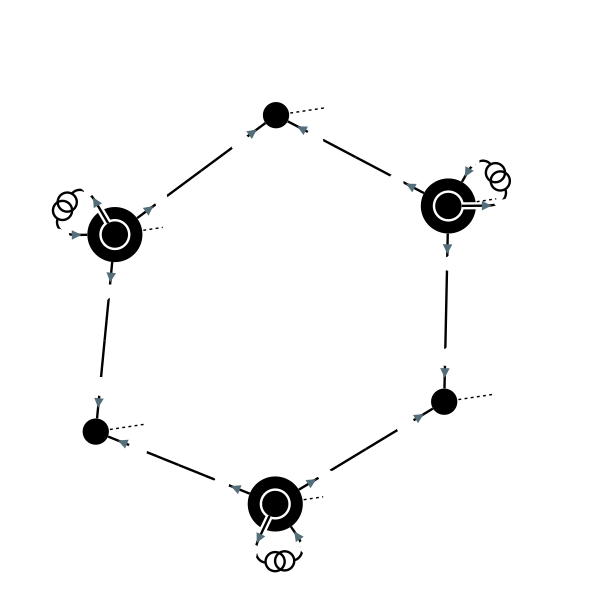

In [10]:
# You can also get the entire network plotted with get_network_area_diagram(). Here the voltage level can be specified, an this returs similar plot, but only for the specified voltage level. 
n_base.get_network_area_diagram()

In [11]:
# The plot can be saved to file as svg. 

path=os.path.join(SAVE_DIR,'ieee9_sld.svg') # using a specified folder to store the plots...
n_base.write_single_line_diagram_svg('VL1',path)

### Customizing the variables

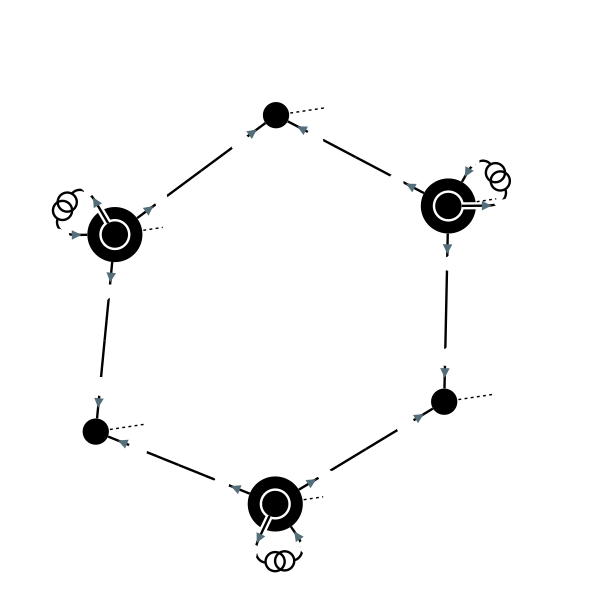

In [69]:
# We now compare the network results to eachother when changing some parameters...
# Load the standard IEEE 9-bus network

n2 = pp.network.create_ieee9() # we can call it n2 now, and keep the default as n_base
results1=pp.loadflow.run_ac(n2)# we run one more, just so we have some results to compare with,
voltages1=n2.get_buses().v_mag # we save the voltages for later (to compare...)
lines_current1=n2.get_lines()[['i1','i2']] # we save the lines for later (to compare...)
n2.get_network_area_diagram()



In [75]:
# we can retrieve the components as variables so that we can save the original values for later (to compare changes)
# Get components as DataFrames for modification
buses = n2.get_buses()
generators = n2.get_generators()
loads = n2.get_loads()#[['p','q' ]]
lines = n2.get_lines()[['r','x']]

In [72]:
#if names are needed it can be printed as this, we can also see some values, like r and x...
print(lines)

           r      x
id                 
L7-8-0  0.85   7.20
L9-8-0  1.19  10.08
L7-5-0  3.20  16.10
L9-6-0  3.90  17.00
L5-4-0  1.00   8.50
L6-4-0  1.70   9.20


In [76]:
# Modify generator parameters
n2.update_generators(
    id='B1-G', 
    target_p=50,  # New active power setpoint (MW)
    target_v=108,  # New voltage setpoint (pu)
    min_p=50,
    max_p=250
)
#check that it has been updated
print(f"Old: {generators[['target_p','target_v']]}")
print(f"New: {n2.get_generators()[['target_p','target_v','bus_id']]}")

# Modify load parameters
n2.update_loads(
    id='B5-L',
    p0=200,  # Active power (MW)
    q0=30   # Reactive power (MVAr)
)
print(f"Old: {loads[['p0','q0']]}")
print(f"New: {n2.get_loads()[['p0','q0']]}")
# Modify line parameters
n2.update_lines(
    id='L5-4-0',
    r=0.1,  # New resistance (pu)
    x=0.5   # New reactance (pu)
)
print(f"Old: {lines[['r','x']]}")
print(f"New: {n2.get_lines()[['r','x']]}")

Old:       target_p  target_v
id                      
B1-G      50.0     108.0
B2-G     163.0     102.5
B3-G      85.0     102.5
New:       target_p  target_v bus_id
id                             
B1-G      50.0     108.0  VL1_0
B2-G     163.0     102.5  VL2_0
B3-G      85.0     102.5  VL3_0
Old:          p0    q0
id               
B5-L  200.0  30.0
B6-L   90.0  30.0
B8-L  100.0  35.0
New:          p0    q0
id               
B5-L  200.0  30.0
B6-L   90.0  30.0
B8-L  100.0  35.0
Old:            r      x
id                 
L7-8-0  0.85   7.20
L9-8-0  1.19  10.08
L7-5-0  3.20  16.10
L9-6-0  3.90  17.00
L5-4-0  0.10   0.50
L6-4-0  1.70   9.20
New:            r      x
id                 
L7-8-0  0.85   7.20
L9-8-0  1.19  10.08
L7-5-0  3.20  16.10
L9-6-0  3.90  17.00
L5-4-0  0.10   0.50
L6-4-0  1.70   9.20


In [34]:
# Just another way of printing the values...
for index,row in lines.iterrows():
    print(f"{index}:r={round(row['r'],2)}, x={round(row['x'],2)}")

L7-8-0:r=0.85, x=7.2
L9-8-0:r=1.19, x=10.08
L7-5-0:r=3.2, x=16.1
L9-6-0:r=3.9, x=17.0
L5-4-0:r=1.0, x=8.5
L6-4-0:r=1.7, x=9.2


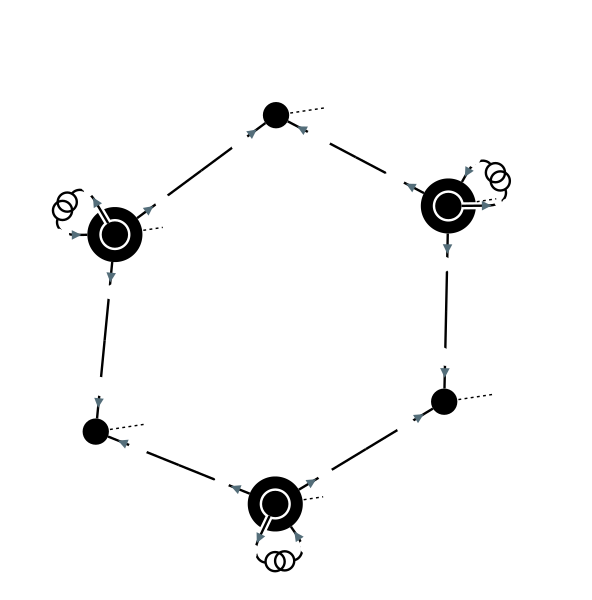

In [18]:
#re-run power flow with updated values
#n2 = pp.network.create_ieee9()
results2=pp.loadflow.run_ac(n2)
pp.loadflow.run_ac(n2)
n2.get_network_area_diagram()

In [68]:
# Print results one item at a time
voltages2=n2.get_buses().v_mag
print(f'Initial results: {voltages1}')
print(f'next results: {voltages2}')
lines_current2=n2.get_lines()[['i1','i2']]
print(f'Initial lines current: {lines_current1}')  
print(f'next lines current: {lines_current2}')  
#print(voltages.loc['VL1_0'])

Initial results: id
VL1_0    104.000000
VL1_1    102.578841
VL2_0    102.500000
VL2_1    102.576939
VL3_0    102.500000
VL3_1    103.235296
VL5_0     99.563088
VL6_0    101.265434
VL8_0    101.588260
Name: v_mag, dtype: float64
next results: id
VL1_0    104.000000
VL1_1    102.578841
VL2_0    102.500000
VL2_1    102.576939
VL3_0    102.500000
VL3_1    103.235296
VL5_0     99.563088
VL6_0    101.265434
VL8_0    101.588260
Name: v_mag, dtype: float64
Initial lines current:                 i1          i2
id                            
L7-8-0  429.924570  435.652249
L9-8-0  136.367931  194.469402
L7-5-0  489.814784  493.340101
L9-6-0  354.824370  347.591012
L5-4-0  325.539102  263.990934
L6-4-0  198.010881  172.908376
next lines current:                 i1          i2
id                            
L7-8-0  429.924570  435.652249
L9-8-0  136.367931  194.469402
L7-5-0  489.814784  493.340101
L9-6-0  354.824370  347.591012
L5-4-0  325.539102  263.990934
L6-4-0  198.010881  172.908376


In [77]:
# Rather make a new variant to keep the initial variant
n2.clone_variant('InitialState', 'NewVariant')
n2.set_working_variant('NewVariant')

#First we can make a function to compare the two variants, and see what has changed.

def compare_variants(network, variant1, variant2, element_type='generators'):
    """
    Compare network elements between two variants

    """
    # Get data for first variant
    network.set_working_variant(variant1)
    if element_type == 'generators':
        df1 = network.get_generators()
    elif element_type == 'loads':
        df1 = network.get_loads()
    elif element_type == 'buses':
        df1 = network.get_buses()
    
    # Get data for second variant
    network.set_working_variant(variant2)
    if element_type == 'generators':
        df2 = network.get_generators()
    elif element_type == 'loads':
        df2 = network.get_loads()
    elif element_type == 'buses':
        df2 = network.get_buses()
    
    # Compare dataframes
    diff_mask = (df1 != df2).any(axis=1)
    differences = pd.concat([
        df1[diff_mask].add_suffix(f'_{variant1}'),
        df2[diff_mask].add_suffix(f'_{variant2}')
    ], axis=1)
    
    return differences

# Modify generator parameters
n2.update_generators(
    id='B1-G', 
    target_p=75,  # New active power setpoint (MW)
    target_v=106,  # New voltage setpoint (pu)
    min_p=50,
    max_p=250
)

# Modify load parameters
n2.update_loads(
    id='B5-L',
    p0=250,  # Active power (MW)
    q0=40   # Reactive power (MVAr)
)
# Modify line parameters
n2.update_lines(
    id='L5-4-0',
    r=0.15,  # New resistance (pu)
    x=0.45   # New reactance (pu)
)

#Lets now compare the two variants, and see what has changed.
gen_diff=compare_variants(n2, 'InitialState', 'NewVariant', element_type='generators')
load_diff=compare_variants(n2, 'InitialState', 'NewVariant', element_type='loads')

In [79]:
# lets run a new power flow simulation with singel slack bus instead of distributed slack bus
n2.set_working_variant('InitialState')
results3=lf.run_ac(n2, parameters=lf.Parameters(distributed_slack=False))
voltages3=n2.get_buses().v_mag
lines_current3=n2.get_lines()[['i1','i2']]
p3=n2.get_generators().p
#q3=n2.get_buses().q0

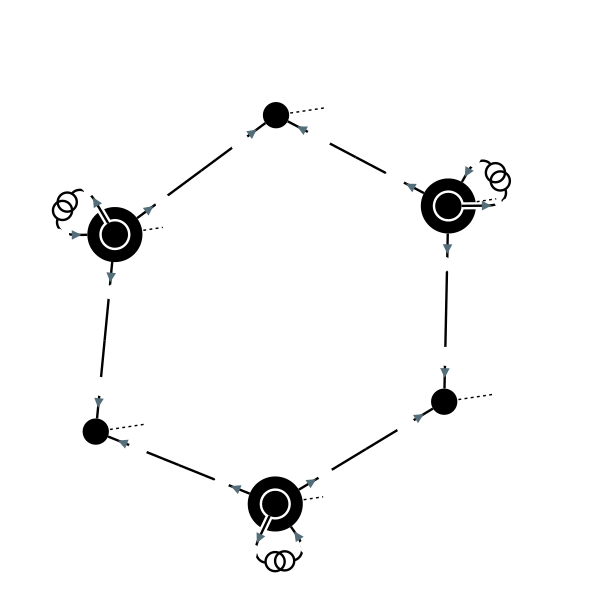

In [82]:
n2.get_network_area_diagram(depth=1)

In [80]:
print(f"Old: {voltages1}")
print(f"New: {voltages2}")
print(f"New2: {voltages3}")

print(f"Old: {lines_current1}")
print(f"New: {lines_current2}")
print(f"New2: {lines_current3}")


Old: id
VL1_0    104.000000
VL1_1    102.578841
VL2_0    102.500000
VL2_1    102.576939
VL3_0    102.500000
VL3_1    103.235296
VL5_0     99.563088
VL6_0    101.265434
VL8_0    101.588260
Name: v_mag, dtype: float64
New: id
VL1_0    104.000000
VL1_1    102.578841
VL2_0    102.500000
VL2_1    102.576939
VL3_0    102.500000
VL3_1    103.235296
VL5_0     99.563088
VL6_0    101.265434
VL8_0    101.588260
Name: v_mag, dtype: float64
New2: id
VL1_0    108.000000
VL1_1    105.799862
VL2_0    102.500000
VL2_1    104.077775
VL3_0    102.500000
VL3_1    104.055489
VL5_0    105.484211
VL6_0    103.719598
VL8_0    102.836597
Name: v_mag, dtype: float64
Old:                 i1          i2
id                            
L7-8-0  429.924570  435.652249
L9-8-0  136.367931  194.469402
L7-5-0  489.814784  493.340101
L9-6-0  354.824370  347.591012
L5-4-0  325.539102  263.990934
L6-4-0  198.010881  172.908376
New:                 i1          i2
id                            
L7-8-0  429.924570  435.652249


In [ ]:
# Get current slack bus(es)
generators_df = n2.get_generators()
print("Initial slack bus status:")
print(generators_df[['name', 'voltage_regulator_on', 'bus_id']])

# Set B1-G as slack bus by updating generator properties
n2.update_generators(
    id=['B1-G'],  # Generator connected to B1 bus
    voltage_regulator_on=[True],
    target_v=[400.0],  # kV
    target_p=[100.0],  # MW
    target_q=[0.0],    # MVAr
    regulated=True
)

# Verify changes
print("\nAfter setting slack bus:")
print(network.get_generators()[['name', 'voltage_regulator_on', 'bus_id']])



Initial slack bus status:
     name  voltage_regulator_on bus_id
id                                    
B1-G                       True  VL1_0
B2-G                       True  VL2_0
B3-G                       True  VL3_0


ValueError: No column named regulated

In [ ]:
# Adding some load variations:
def create_ieee9_time_series(steps=5, p_set_gen2=163, p_set_gen3=85):
    # Create the IEEE 9-bus network
    network = pp.network.create_ieee9()
    
    # Define time steps
    snapshots = pd.date_range("2025-01-01 00:00", periods=steps, freq="h")
    
    # Define base loads and variation patterns
    base_loads = {
        'B5-L': {'p': 90, 'q': 30},
        'B6-L': {'p': 100, 'q': 35},
        'B8-L': {'p': 125, 'q': 50}
    }
    
    # Define oscillation patterns similar to PyPSA implementation
    base_patterns = {
        'B5-L': np.array([1, 1, 1, -1, -1]),
        'B6-L': np.array([0, 1, 1, -1, -1]),
        'B8-L': np.array([0, 0, 1, 0, -1])
    }
    
    variation = 0.1  # 30% variation
    
    # Store results for each time step
    results = {}
    load_values = {load_id: {'p': [], 'q': []} for load_id in base_loads.keys()}
    generator_values = {'B1-G': [], 'B2-G': [], 'B3-G': []}
    
    # Set generator values
    network.update_generators(id='B2-G', target_p=p_set_gen2)
    network.update_generators(id='B3-G', target_p=p_set_gen3)
    
    # Create and simulate each time step
    for step in range(min(steps, 5)):
        # Create a variant for this time step
        variant_id = f"step_{step}" # we have used the step_number as variant id
        network.clone_variant('InitialState',variant_id) # network is updated to include this variant...
        network.set_working_variant(variant_id) # here is where the equivalent to "snapshot" in pypsa is set, in powsybl it is called "working_variant"
        
        #with this working variant we can now make some changes to load, or to other grid characteristics
        # Update loads based on patterns
        for load_id, base_load in base_loads.items():
            pattern_value = base_patterns[load_id][step]
            p_value = base_load['p'] * (1 + variation * pattern_value)
            q_value = base_load['q'] * (1 + variation * pattern_value)
            
            network.update_loads(id=load_id, p0=p_value, q0=q_value)
            load_values[load_id]['p'].append(p_value)
            load_values[load_id]['q'].append(q_value)
        
        # Run load flow for this time step
        result = pp.loadflow.run_ac(network)
        results[step] = result
        
        # Get generator output for this time step
        generators = network.get_generators()
        for gen_id in ['B1-G', 'B2-G', 'B3-G']:
            #gen_data = generators[generators['id'] == gen_id]
            gen_data = generators[generators.index == gen_id]
            if not gen_data.empty:
                generator_values[gen_id].append(gen_data['p'].values[0])
        
        # Reset to base variant for next iteration
        network.set_working_variant("InitialState")
    
    return network, results, load_values, generator_values, snapshots



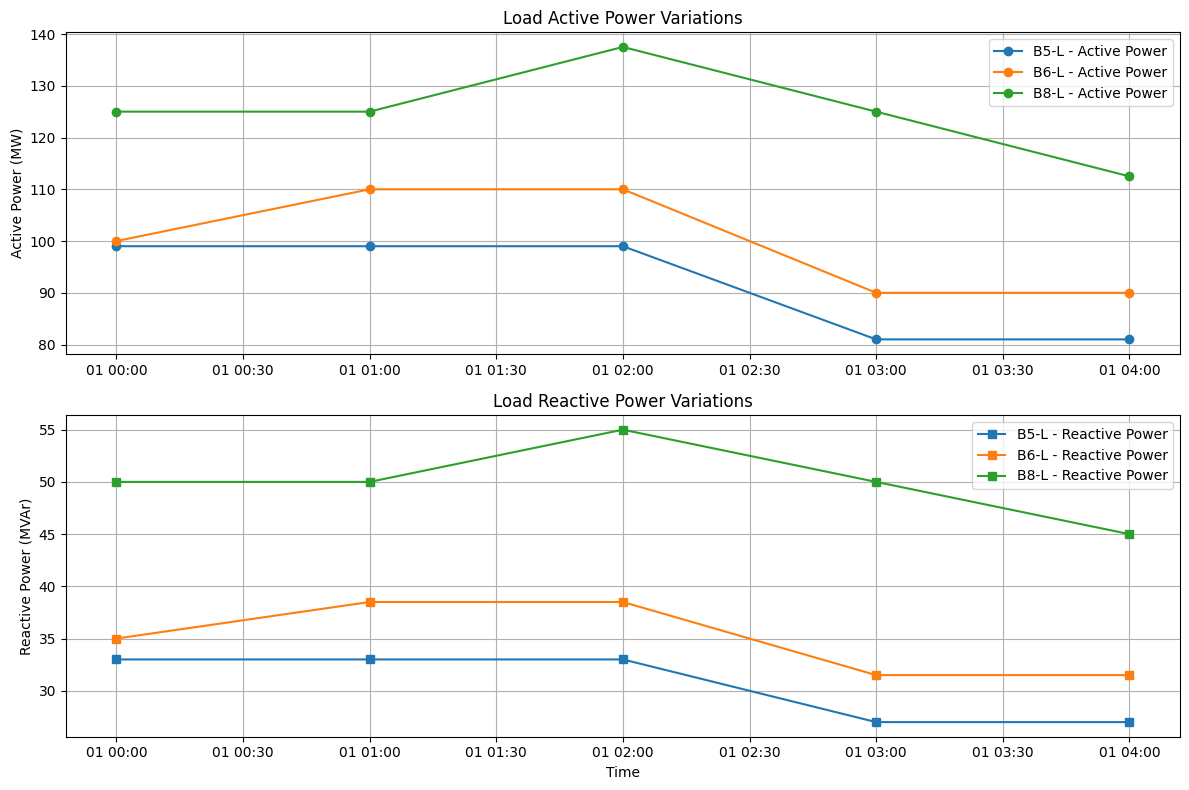

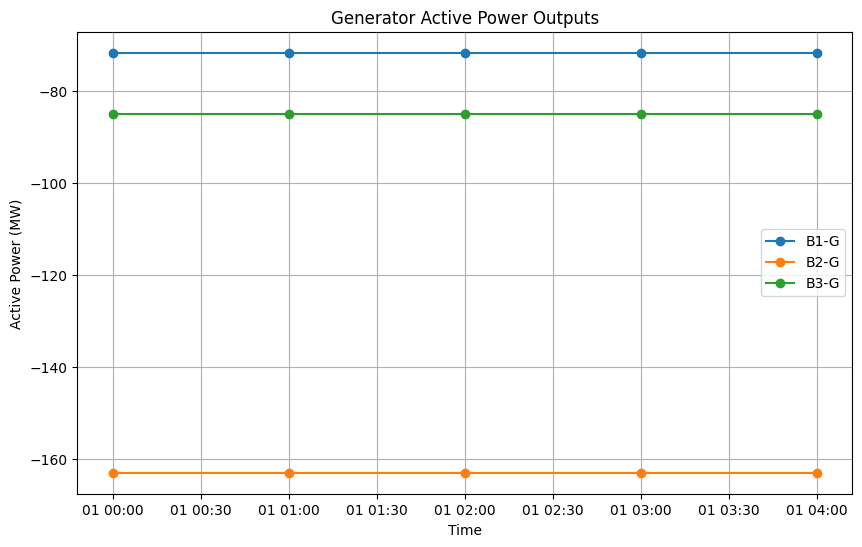

In [63]:
# We can now use the procedure above to create time series simulation
network, results, load_values, generator_values, snapshots = create_ieee9_time_series()

# Plot load variations
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
for load_id, values in load_values.items():
    plt.plot(snapshots, values['p'], marker='o', label=f"{load_id} - Active Power")
plt.title('Load Active Power Variations')
plt.ylabel('Active Power (MW)')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
for load_id, values in load_values.items():
    plt.plot(snapshots, values['q'], marker='s', label=f"{load_id} - Reactive Power")
plt.title('Load Reactive Power Variations')
plt.xlabel('Time')
plt.ylabel('Reactive Power (MVAr)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot generator outputs
plt.figure(figsize=(10, 6))
for gen_id, values in generator_values.items():
    plt.plot(snapshots, values, marker='o', label=gen_id)
plt.title('Generator Active Power Outputs')
plt.xlabel('Time')
plt.ylabel('Active Power (MW)')
plt.legend()
plt.grid(True)
plt.show()

## Plotting the results for timesteps as for PyPSA

In [3]:
def create_ieee9_time_series_complete(steps=5, p_set_gen2=163, p_set_gen3=85):
    # Create the IEEE 9-bus network
    network = pp.network.create_ieee9()
    
    # Define time steps
    snapshots = pd.date_range("2025-01-01 00:00", periods=steps, freq="h")
    
    # Define base loads and variation patterns
    base_loads = {
        'B5-L': {'p': 90, 'q': 30},
        'B6-L': {'p': 100, 'q': 35},
        'B8-L': {'p': 125, 'q': 50}
    }
    
    # Define oscillation patterns
    base_patterns = {
        'B5-L': np.array([1, 1, 1, -1, -1]),
        'B6-L': np.array([0, 1, 1, -1, -1]),
        'B8-L': np.array([0, 0, 1, 0, -1])
    }
    
    variation = 0.3  # 30% variation
    
    # Store results for each time step
    results = {}
    
    # Get buses, lines, and transformers
    buses = network.get_buses()
    lines = network.get_lines()
    transformers = network.get_2_windings_transformers()
    
    # Initialize bus results dataframe
    bus_results = pd.DataFrame(
        index=snapshots,
        columns=pd.MultiIndex.from_product([
            buses.index,
            ['P (MW)', 'Q (MVAr)', 'V (pu)', 'Angle (deg)']
        ])
    )
    
    # Initialize line results dataframe
    line_results = pd.DataFrame(
        index=snapshots,
        columns=pd.MultiIndex.from_product([
            list(lines.index) + list(transformers.index),
            ['P0 (MW)', 'P1 (MW)', 'Q0 (MVAr)', 'Q1 (MVAr)']
        ])
    )
    
    # Set generator values
    network.update_generators(id='B2-G', target_p=p_set_gen2)
    network.update_generators(id='B3-G', target_p=p_set_gen3)
    
    # Create and simulate each time step
    for step in range(min(steps, 5)):
        # Create a variant for this time step
        variant_id = f"step_{step}"
        network.clone_variant("InitialState", variant_id)
        network.set_working_variant(variant_id)
        
        # Update loads based on patterns
        for load_id, base_load in base_loads.items():
            pattern_value = base_patterns[load_id][step]
            p_value = base_load['p'] * (1 + variation * pattern_value)
            q_value = base_load['q'] * (1 + variation * pattern_value)
            
            network.update_loads(id=load_id, p0=p_value, q0=q_value)
        
        # Run load flow for this time step
        result = pp.loadflow.run_ac(network)
        results[step] = result
        
        # Get updated data after load flow
        updated_buses = network.get_buses()
        updated_lines = network.get_lines()
        updated_transformers = network.get_2_windings_transformers()
        
        # Store bus results
        for _, bus in updated_buses.iterrows():
            bus_id = bus.name
            voltage_level_id = bus['voltage_level_id']
            voltage_levels = network.get_voltage_levels()
            voltage_level = voltage_levels[voltage_levels.index == voltage_level_id].iloc[0]
            
            # Get bus P and Q from injections
            p_total = 0
            q_total = 0
            
            # Add generator injections
            generators = network.get_generators()
            for _, gen in generators[generators['bus_id'] == bus_id].iterrows():
                p_total += gen['target_p']
                q_total += gen['target_q']
            
            # Subtract load consumption
            loads = network.get_loads()
            for _, load in loads[loads['bus_id'] == bus_id].iterrows():
                p_total -= load['p0']
                q_total -= load['q0']
            
            # Store bus results
            bus_results.loc[snapshots[step], (bus_id, 'P (MW)')] = p_total
            bus_results.loc[snapshots[step], (bus_id, 'Q (MVAr)')] = q_total
            bus_results.loc[snapshots[step], (bus_id, 'V (pu)')] = bus['v_mag'] / voltage_level['nominal_v']
            bus_results.loc[snapshots[step], (bus_id, 'Angle (deg)')] = bus['v_angle']
        
        # Store line results
        for _, line in updated_lines.iterrows():
            line_id = line.name
            line_results.loc[snapshots[step], (line_id, 'P0 (MW)')] = line['p1']
            line_results.loc[snapshots[step], (line_id, 'P1 (MW)')] = line['p2']
            line_results.loc[snapshots[step], (line_id, 'Q0 (MVAr)')] = line['q1']
            line_results.loc[snapshots[step], (line_id, 'Q1 (MVAr)')] = line['q2']
        
        # Store transformer results
        for _, transformer in updated_transformers.iterrows():
            transformer_id = transformer.name
            line_results.loc[snapshots[step], (transformer_id, 'P0 (MW)')] = transformer['p1']
            line_results.loc[snapshots[step], (transformer_id, 'P1 (MW)')] = transformer['p2']
            line_results.loc[snapshots[step], (transformer_id, 'Q0 (MVAr)')] = transformer['q1']
            line_results.loc[snapshots[step], (transformer_id, 'Q1 (MVAr)')] = transformer['q2']
        
        # Reset to base variant for next iteration
        network.set_working_variant("InitialState")
    
    return network, results, bus_results, line_results, snapshots

In [4]:
def plot_network_results(network, results_df):
    """
    Plot network results in 4 subplots: P, Q, V_mag, and V_ang with bus types in legend
    """
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
    
    # Get data for each bus
    buses = network.get_buses()
    loads = network.get_loads()
    generators = network.get_generators()
    
    for bus_id in buses.index:
        # Determine bus type for legend
        if bus_id in loads['bus_id'].values:
            bus_type = f"{bus_id} (Load)"
        elif bus_id in generators['bus_id'].values:
            gen = generators[generators['bus_id'] == bus_id]
            if 'B1-G1' in gen.index.values:  # Assuming GEN1 is slack
                bus_type = f"{bus_id} (Gen-Slack)"
            else:
                bus_type = f"{bus_id} (Gen-PV)"
        else:
            bus_type = bus_id
            
        # Active Power (P)
        ax1.plot(results_df.index, results_df[bus_id]['P (MW)'], marker='o', label=bus_type)
        ax1.set_ylabel('P (MW)')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.grid(True)
        
        # Reactive Power (Q)
        ax2.plot(results_df.index, results_df[bus_id]['Q (MVAr)'], marker='o', label=bus_type)
        ax2.set_ylabel('Q (MVAr)')
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax2.grid(True)
        
        # Voltage Magnitude
        ax3.plot(results_df.index, results_df[bus_id]['V (pu)'], marker='o', label=bus_type)
        ax3.set_ylabel('Voltage (p.u.)')
        ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax3.grid(True)
        
        # Voltage Angle
        ax4.plot(results_df.index, results_df[bus_id]['Angle (deg)'], marker='o', label=bus_type)
        ax4.set_ylabel('Angle (degrees)')
        ax4.set_xlabel('Time')
        ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax4.grid(True)

    plt.tight_layout()
    plt.show()

def plot_line_results(network, results_df):
    """
    Plot line flow results with one subplot per line, showing P0/P1 and Q0/Q1
    """
    # Get all branches (lines and transformers)
    lines = network.get_lines()
    transformers = network.get_2_windings_transformers()
    all_branches = list(lines.index) + list(transformers.index)
    
    n_branches = len(all_branches)
    fig, axs = plt.subplots(n_branches, 2, figsize=(12, 2*n_branches), sharex=True)
    
    # Handle case with only one branch
    if n_branches == 1:
        axs = [axs]
    
    # Get data for each branch
    for i, branch_id in enumerate(all_branches):
        # Get branch details
        if branch_id in lines.index.values:
            branch = lines[lines.index == branch_id].iloc[0]
            s_nom = branch['s_nom'] if 's_nom' in branch else None
            
            # Get connected buses
            from_bus = branch['bus1_id']
            to_bus = branch['bus2_id']
        else:
            branch = transformers[transformers.index == branch_id].iloc[0]
            s_nom = None  # Transformers might not have s_nom directly accessible
            
            # Get connected buses
            from_bus = branch['bus1_id']
            to_bus = branch['bus2_id']
        
        branch_name = f"{branch_id} ({from_bus}->{to_bus})"
        
        # Active Power (P) - Left subplot
        axs[i][0].plot(results_df.index, results_df[branch_id]['P0 (MW)'], marker='o', 
                label=f"P-in (from {from_bus})")
        axs[i][0].plot(results_df.index, -results_df[branch_id]['P1 (MW)'], marker='s', 
                label=f"P-out (to {to_bus})")
        
        # Add S_nom reference lines if available
        if s_nom is not None:
            axs[i][0].axhline(y=s_nom, color='r', linestyle='--', 
                            label=f"S_nom = {s_nom} MVA")
            axs[i][0].axhline(y=-s_nom, color='r', linestyle='--')
        
        axs[i][0].set_ylabel('P (MW)')
        axs[i][0].set_title(f"Active Power Flow - {branch_name}")
        axs[i][0].legend()
        axs[i][0].grid(True)
        
        # Reactive Power (Q) - Right subplot
        axs[i][1].plot(results_df.index, results_df[branch_id]['Q0 (MVAr)'], marker='o', 
                label=f"Q-in (from {from_bus})")
        axs[i][1].plot(results_df.index, -results_df[branch_id]['Q1 (MVAr)'], marker='s', 
                label=f"Q-out (to {to_bus})")
        axs[i][1].set_ylabel('Q (MVAr)')
        axs[i][1].set_title(f"Reactive Power Flow - {branch_name}")
        axs[i][1].legend()
        axs[i][1].grid(True)
        
    # Add common x-axis label
    fig.text(0.5, 0.04, 'Time', ha='center')
    
    plt.tight_layout()
    plt.show()

In [5]:
# Run the simulation and get results
network, results, bus_results, line_results, snapshots = create_ieee9_time_series_complete()

# Plot network results
plot_network_results(network, bus_results)

# Plot line results
plot_line_results(network, line_results)

NameError: name 'pp' is not defined

In [83]:
print(n2.get_voltage_levels('VL4'))

    name substation_id  nominal_v  high_voltage_limit  low_voltage_limit  \
id                                                                         
VL1                 S1      100.0                 NaN                NaN   
VL2                 S2      100.0                 NaN                NaN   
VL3                 S3      100.0                 NaN                NaN   
VL5                 S5      100.0                 NaN                NaN   
VL6                 S6      100.0                 NaN                NaN   
VL8                 S8      100.0                 NaN                NaN   

     fictitious topology_kind  
id                             
VL1       False   BUS_BREAKER  
VL2       False   BUS_BREAKER  
VL3       False   BUS_BREAKER  
VL5       False   BUS_BREAKER  
VL6       False   BUS_BREAKER  
VL8       False   BUS_BREAKER  


In [110]:
print(results.get_default_provider())


AttributeError: 'dict' object has no attribute 'get_default_provider'